                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       cart     5773203  1487580005134238553   
1  2019-10-01 00:00:03 UTC       cart     5773353  1487580005134238553   
2  2019-10-01 00:00:07 UTC       cart     5881589  2151191071051219817   
3  2019-10-01 00:00:07 UTC       cart     5723490  1487580005134238553   
4  2019-10-01 00:00:15 UTC       cart     5881449  1487580013522845895   

  category_code   brand  price    user_id  \
0           NaN  runail   2.62  463240011   
1           NaN  runail   2.62  463240011   
2           NaN  lovely  13.48  429681830   
3           NaN  runail   2.62  463240011   
4           NaN  lovely   0.56  429681830   

                           user_session  
0  26dd6e6e-4dac-4778-8d2c-92e149dab885  
1  26dd6e6e-4dac-4778-8d2c-92e149dab885  
2  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
3  26dd6e6e-4dac-4778-8d2c-92e149dab885  
4  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
event_type
view                1

/var/folders/9s/4p1jdyt11_s10c5t1c3_3s240000gn/T/ipykernel_30488/192825875.py:24: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['cohort_week'] = df['cohort_date'].dt.to_period('W')
/var/folders/9s/4p1jdyt11_s10c5t1c3_3s240000gn/T/ipykernel_30488/192825875.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['event_week'] = df['event_time'].dt.to_period('W')


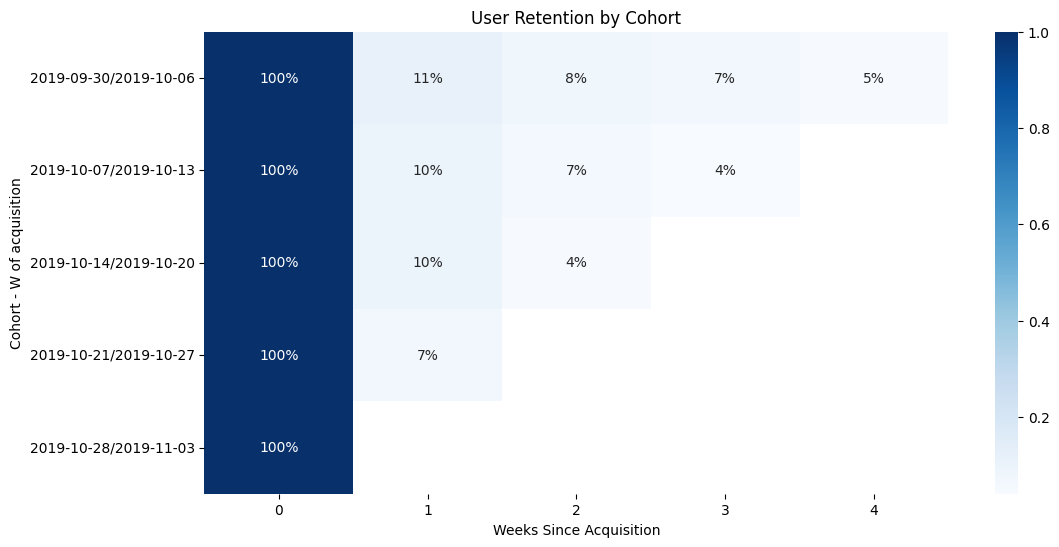

FileNotFoundError: [Errno 2] No such file or directory: 'images/retention_heatmap.png'

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

path = kagglehub.dataset_download("mkechinov/ecommerce-events-history-in-cosmetics-shop")

df = pd.read_csv(f"{path}/2019-Oct.csv")
print(df.head())
print(df['event_type'].value_counts())
print(path)

## Converting dates into datetime
df['event_time'] = pd.to_datetime(df['event_time'])

## Keeping the columns we need and delete duplicates
df = df[['user_id', 'event_time', 'event_type']]
df = df.drop_duplicates()

## Creating cohorts: user activation, cohort week and event week
df['cohort_date'] = df.groupby('user_id')['event_time'].transform('min')

df['cohort_week'] = df['cohort_date'].dt.to_period('W')

df['event_week'] = df['event_time'].dt.to_period('W')

## Retention 

cohort_data = (
    df.groupby (['cohort_week', 'event_week'])
    .agg(n_users=('user_id', 'nunique'))
    .reset_index()
)

cohort_size = (
    df.groupby ('cohort_week')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id' : 'cohort_size'})

)
cohort_data = cohort_data.merge(cohort_size, on='cohort_week')

cohort_data['weeks_since'] = (cohort_data['event_week'].astype(int) - cohort_data['cohort_week'].astype(int))

cohort_data['retention'] = cohort_data['n_users'] / cohort_data['cohort_size']

## Heatmap for visualisation cohort x semaine

retention_matrix = cohort_data.pivot_table (
    index='cohort_week',
    columns='weeks_since',
    values='retention'
)

plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap="Blues")
plt.title("User Retention by Cohort")
plt.ylabel("Cohort - W of acquisition")
plt.xlabel("Weeks Since Acquisition")
plt.show()
plt.savefig('images/retention_heatmap.png')
